# Распознавание рукописных цифр (MNIST)

В этой работе вам предстоит обучить модель классификации рукописных цифр на Tensorflow.

Важным этапом будет сохранение чекпоинтов на ваш гугл диск (не переживайте ниже будут подсказки как это сделать). Это пригодится вам в дальнейшем при обучении более сложных моделей, на случай потери данных при неожиданном отключении Colab.

In [ ]:
import tensorflow as tf
print(tf.__version__)
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

2.3.0


####Вспомогательный код

In [ ]:
#@title 
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

def show_progress(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["acc"],label='train accuracy')
    plt.plot(history["val_acc"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

## Загрузка данных

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

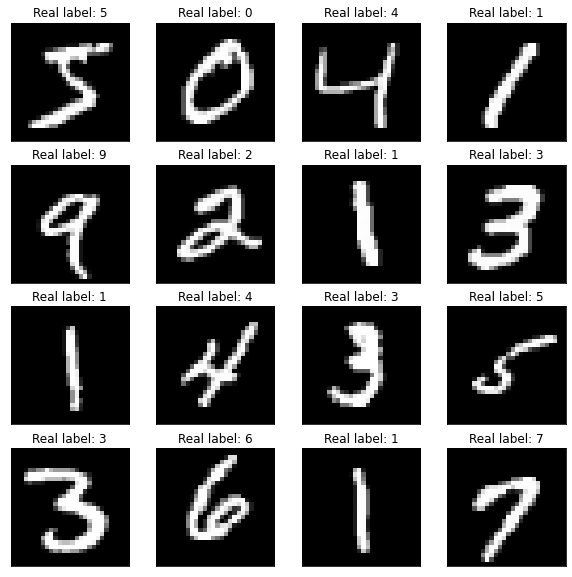

In [ ]:
show_mnist(x_train, y_train)
x_train = x_train.reshape((-1, 28*28)) # вытянули каждую картинку в вектор
x_test = x_test.reshape((-1, 28*28))

In [ ]:
x_train, x_test2, y_train, y_test2 = train_test_split(x_train, y_train, test_size = 0.20, stratify = y_train)

In [ ]:
x_train.shape

(48000, 784)

In [ ]:
# прикрепим ваш гугл диск к виртуальной машине
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Путь до вашего гугл диска скорее всего выглядит так: /content/drive/My Drive/
# если эта клетка вызывает ошибку, 
# измените путь согласно ! ls "/content/drive/"

path = Path("/content/drive/My Drive/MNIST/model_1")
path.mkdir(exist_ok = True, parents = True) # папка создается на вашем гугл диске. вместе с "родителями"
assert path.exists()
cpt_filename = "best_model_MNIST_checkpoint.hdf5"  
cpt_path =str(path / cpt_filename)
# После выполнения этой клетки, в вашем гугл диске должна создаться папка: MNIST/model_1
# убедитесь в этом

Далее приступаем к инициализации и обучению модели. Мы будем использовать обычную полносвязную нейронную сеть.
И конечно же не забываем сохранять модель с лучшими параметрами на google-диск

Вы можете сами эксперементировать с архитектурой модели, а также её гиперпараметрами и посмотреть как изменится результат.

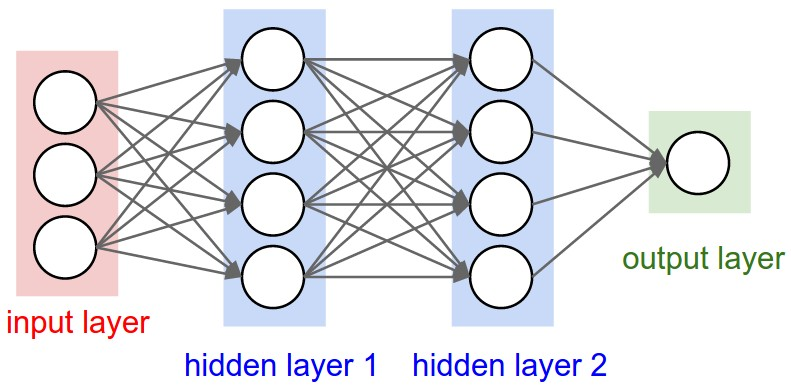

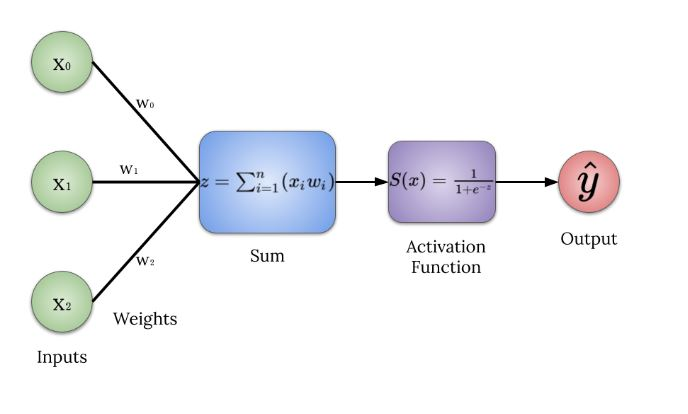

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape = (28*28)),

  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units = 32, activation = 'tanh', kernel_initializer = 'glorot_uniform'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units = 32, activation = 'tanh', kernel_initializer = 'glorot_uniform'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation = 'softmax')
])                                                           # Создаём архитектуру модели.

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])                             # Определяем гиперпараметры для обучения.

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = cpt_path, save_weights_only = True, verbose = 1) # Определяем куда и как сохранять чекпоинты модели.

history = model.fit(x_train, y_train, epochs = 50, callbacks = [cp_callback], validation_split = 0.2, batch_size = 64)         # Обучаем модель

In [ ]:
model.summary()

In [ ]:
plot_model(model)

Далее следует код, проверяющий корректность проделанной работы.

In [ ]:
assert len(list(path.glob("*"))) != 0, f"Checkpoint dir {path}"
assert "acc" in history.history, "History object must contain Accuracy. Please, retrain with this metric"
assert "val_acc" in history.history, "Please, provide validation_data in model.fit."
assert np.max(history.history["val_acc"]) > 0.95, "Validation accuracy must be more than 0.95"
print("Training tests passed")

Давайте посмотрим на графики обучения. По оси "х" у нас идут эпохи, по оси "y" - точность классификации.

In [ ]:
show_progress(history.history)

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

print(f"Accuracy of restored model {acc*100 :.2f}%")
assert acc > 0.96

И, наконец, можно сравнить предсказания с реальными классами (с такой точностью найти ошибку будет сложно):

In [ ]:
predicted_labels = model.predict_classes(x_test)

In [ ]:
idxs = np.random.choice(np.arange(len(x_test)), 16, replace=False)
show_mnist(x_test[idxs].reshape((-1, 28, 28)), y_test[idxs], predicted_labels[idxs])

А теперь перейдем к загрузке модели. Если все реализовано правильно, то код ниже должен сработать без ошибок:

In [ ]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape = (28*28)),

  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units = 32, activation = 'tanh', kernel_initializer = 'glorot_uniform'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units = 32, activation = 'tanh', kernel_initializer = 'glorot_uniform'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation = 'softmax')
]) 

model2.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])  

In [ ]:
model2.load_weights(cpt_path)
loss, acc = model2.evaluate(x_test2, y_test2)

print(f"Accuracy of restored model {acc*100 :.2f}%")
assert acc > 0.96

Теперь решим эту задачу с помощью сверточной нейронной сети

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

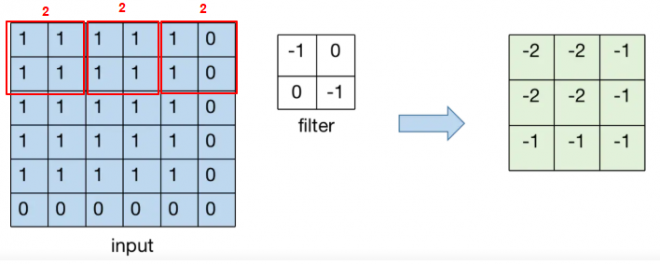

https://i.stack.imgur.com/Tnfmi.gif

https://i.stack.imgur.com/uEoXw.gif

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (28, 28, 1)),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 8, kernel_size = 2, padding = 'same', activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units = 64, activation = 'tanh', kernel_initializer = 'glorot_uniform'),

  tf.keras.layers.Dense(10, activation = 'softmax')
])                                                           # Создаём архитектуру модели.

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])                             # Определяем гиперпараметры для обучения.

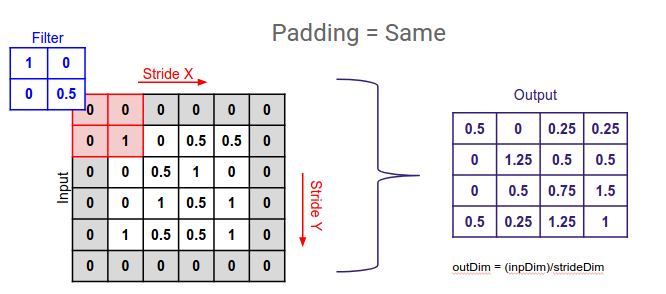

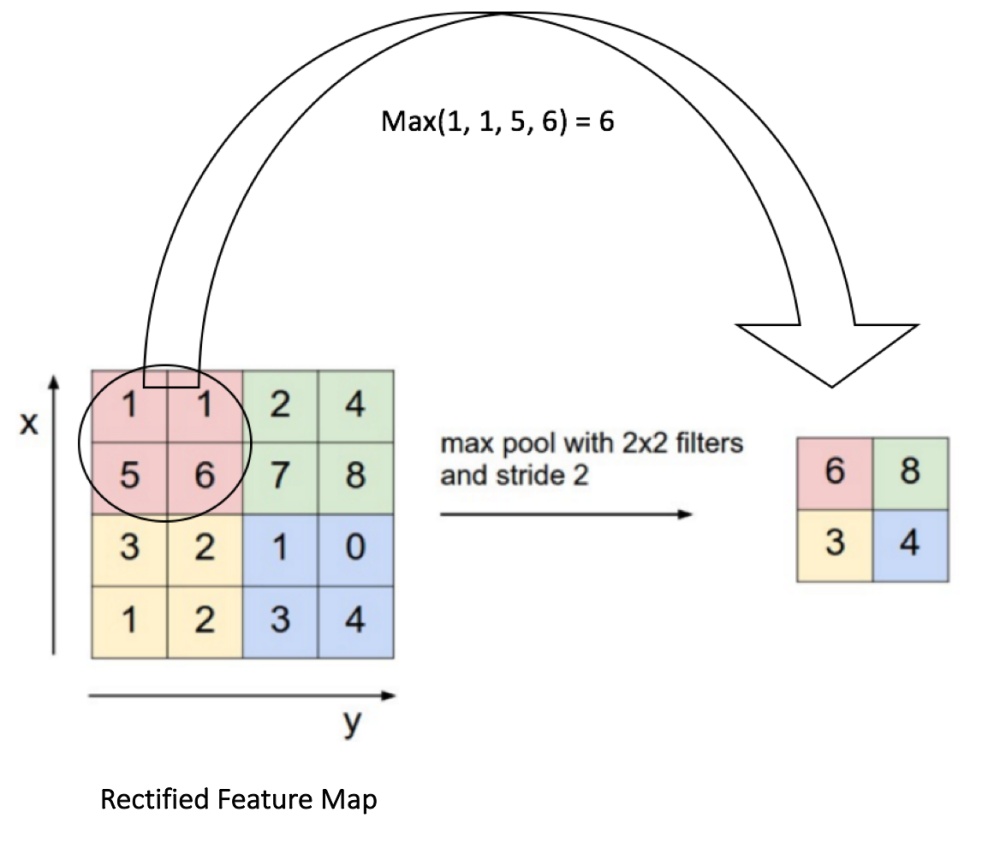

In [ ]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 28, 28, 32)        160       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 16)        2064      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 7, 7, 8)           520       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 3, 3, 8)           0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 72)              

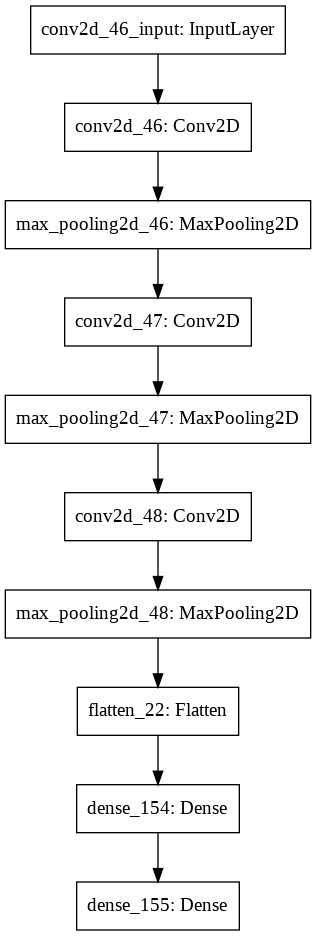

In [ ]:
plot_model(model)

In [ ]:
history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2, batch_size = 64)    # Обучаем модель

Epoch 1/10
750/750 [==============================] - 28s 37ms/step - loss: 0.4365 - acc: 0.8694 - val_loss: 0.1469 - val_acc: 0.9568
Epoch 2/10
750/750 [==============================] - 28s 37ms/step - loss: 0.1279 - acc: 0.9607 - val_loss: 0.1047 - val_acc: 0.9691
Epoch 3/10
750/750 [==============================] - 28s 37ms/step - loss: 0.0983 - acc: 0.9694 - val_loss: 0.1010 - val_acc: 0.9678
Epoch 4/10
750/750 [==============================] - 28s 37ms/step - loss: 0.0813 - acc: 0.9747 - val_loss: 0.0819 - val_acc: 0.9757
Epoch 5/10
750/750 [==============================] - 28s 37ms/step - loss: 0.0713 - acc: 0.9778 - val_loss: 0.0741 - val_acc: 0.9779
Epoch 6/10
750/750 [==============================] - 28s 37ms/step - loss: 0.0639 - acc: 0.9795 - val_loss: 0.0737 - val_acc: 0.9783
Epoch 7/10
750/750 [==============================] - 28s 37ms/step - loss: 0.0581 - acc: 0.9817 - val_loss: 0.0647 - val_acc: 0.9804
Epoch 8/10
750/750 [==============================] - 28s 37ms

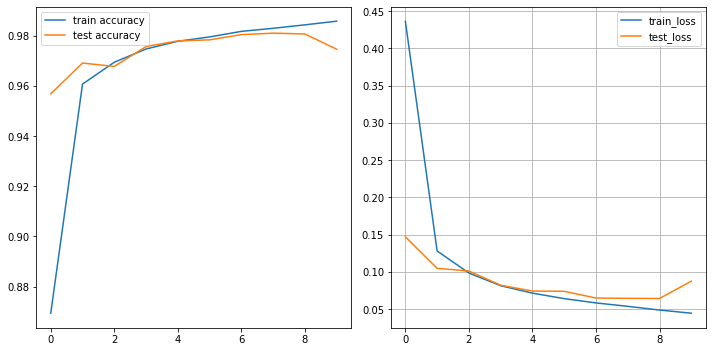

In [ ]:
show_progress(history.history)

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0498 - acc: 0.9848


In [ ]:
print(f"Accuracy of restored model {acc*100 :.2f}%")
assert acc > 0.96

Accuracy of restored model 98.48%
